### Define and train models for text classification

#### Make imports

In [89]:
import torch
import numpy as np
import pickle
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing as skp
from IPython.display import Image
import torch.optim as optim
from tqdm import tqdm_notebook, tqdm
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cpu")

In [3]:
os.chdir('disk/ERIK_ML/')

#### Load dataset

In [4]:
X_train = np.load('X_train_padded.npy')
X_test = np.load('X_test_padded.npy')
embeddings = np.load('embeddings_classification.npy')
y_test = np.load('y_test.npy')
y_train = np.load('y_train.npy')

In [21]:
f = open('idx2word_X.pkl','rb')
idx2word_X = pickle.load(f)
f.close()

In [5]:
N_CLASSES = np.unique(y_train).shape[0]

In [6]:
N_TRAINING = X_train.shape[0]
N_TESTING = X_test.shape[0]

In [7]:
# encode targets in order to use them to create a tensor dataset
encoder = skp.LabelEncoder()
y_train = encoder.fit_transform(y_train)
encoder = skp.LabelEncoder()
y_test = encoder.fit_transform(y_test)

#### Create TensorDataset

In [8]:
BATCH_SIZE = 64

In [9]:
train_data = TensorDataset(torch.LongTensor(X_train).to(device), torch.LongTensor(y_train).to(device))
test_data = TensorDataset(torch.LongTensor(X_test).to(device), torch.LongTensor(y_test).to(device))
train_data_loader = DataLoader(train_data, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True)
test_data_loader = DataLoader(test_data, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True)

In [10]:
NUM_EMBEDDINGS = embeddings.shape[0]
N_DIM = embeddings.shape[1]
HIDDEN_DIM = 128

#### Define training function

In [11]:
def train(model, loss, optimizer):
    training_loss = []
    training_accuracy = []
    test_loss = []
    test_accuracy = []
    for epoch in range(1,EPOCHS+1):
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        # loop over the training data
        for X,y in tqdm_notebook(train_data_loader):
            # zero gradient
            optimizer.zero_grad()
            # forward pass
            #print('X',X.device) X cuda:0
            #print('y',y.device) y cuda:0
            logits = model(X)
            #print(logits.device) cuda:0 
            
            cost = loss(logits[0].squeeze(), y)
            #print(cost.device) cuda:0
            # compute gradient
            cost.backward()
            # optimization
            optimizer.step()
            epoch_loss+=cost.item()
            
            # calculate accuracy
            prediction = torch.argmax(logits[0],dim = -1)
            #print(prediction.device) cuda:0
            #print('sum: ',torch.sum(prediction.squeeze().eq(y)))
            #print(torch.sum(prediction.squeeze().eq(y)).item()/64.)
            accuracy = torch.sum(prediction.squeeze().eq(y)).item()/64.
            #print(accuracy)
            #return
            #print(prediction.size()[0])
            
            epoch_accuracy += accuracy
            #print(accuracy.device) cuda:0
            #break
        print('Training loss in the {}. epoch: '.format(epoch),epoch_loss/1329)
        training_loss.append(epoch_loss/1329)
        print('Training accuray in the {}. epoch: '.format(epoch),epoch_accuracy/1329)
        training_accuracy.append(epoch_accuracy/1329)
        # loop over test data
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        
        if epoch%1==0:
            for X_test,y_test in tqdm(test_data_loader):
                logits = model(X_test)
                cost = loss(logits[0], y_test)
                epoch_loss+=cost.item() # compute running loss
                # calculate accuracy
                prediction = torch.argmax(logits[0],dim = -1)
                #print(prediction.detatch().to('cpu').size())
                #print(prediction.size())
                accuracy = torch.sum(prediction.squeeze().eq(y_test)).item()/64.
                epoch_accuracy += accuracy

            print('Test loss in the {}. epoch: '.format(epoch),epoch_loss/(N_TEST//BATCH_SIZE))
            test_loss.append(epoch_loss/(N_TEST//BATCH_SIZE))
            print('Test accuracy in the {}. epoch: '.format(epoch),epoch_accuracy/(N_TEST//BATCH_SIZE))
            test_accuracy.append(epoch_accuracy/(N_TEST//BATCH_SIZE))
            

#### Train the model

In [12]:
EPOCHS = 5

#### Classifier model

##### LSTM layer

In [13]:
class LSTM_layer(nn.Module):
    def __init__(self):
        super(LSTM_layer,self).__init__()
        self.embedding = torch.nn.Embedding(NUM_EMBEDDINGS,N_DIM,_weight=torch.Tensor(embeddings).to(device))
        self.lstm = torch.nn.LSTM(N_DIM,HIDDEN_DIM,bidirectional = True,batch_first = True).to(device)
        # add dropout 
        self.dropout = nn.Dropout(0.5).to(device)
    def forward(self,input_):
        input_ = self.embedding(input_)
        #print('embedded size',input_.size())
        full_sequence,b = self.lstm(input_)
        full_sequence = self.dropout(full_sequence)
  
        #print('lstm sequences size',output.size()) [BATCH, SEQ_LEN, 256]
        #print('lstm sequences last',output[0,0,128:])
        #print('hidden state size : {}, cell state size : {}'.format(b[0].size(),b[1].size()))
        #print('hidden state size : {}'.format(b[0][1,0]))
        #print('series through linear : ',output.size())
        
        # concatenate the hidden states to use them later 
        #last_hidden_state = torch.cat([b[0][0],b[0][1],b[1][0],b[1][1]],dim = -1).to(device)
        last_hidden_state = torch.cat([b[0][0],b[0][1]],dim = -1).to(device)
        last_hidden_state = self.dropout(last_hidden_state)
        #print(last_hidden_state.size()) # torch.Size([BATCH, 512])
        return full_sequence, last_hidden_state

##### Attention layer

In [14]:
class Attention_layer(nn.Module):
    def __init__(self):
        super(Attention_layer,self).__init__()
        self.sequence_transformer = nn.Linear(HIDDEN_DIM*2,HIDDEN_DIM)
        self.last_state_transformer = nn.Linear(HIDDEN_DIM*2,HIDDEN_DIM)
        self.dimension_reducer = nn.Linear(HIDDEN_DIM,1)
    def forward(self, last_state, sequence):
        last_state = last_state.view(last_state.size()[0],
                                1,
                                last_state.size()[1])
        #print('new last state size: ',last_state.size()) # torch.Size([BATCH, 1, 512])
        seq_logits = self.dimension_reducer(
                    torch.tanh(
                    self.sequence_transformer(sequence) + 
                    self.last_state_transformer(last_state)
                    )
        )
        #print(seq_logits.size()) # ([BACH, SEQ_LEN, 1])
        attention_weights = F.softmax(seq_logits,dim = 1)
        #print(attention_weights.size()) # torch.Size([BATCH, SEQ_LEN, 1])
        
        context_vector = attention_weights*sequence
        #print(context_vector.size()) # [BATCH, SEQ_LEN, HIDDEN_DIM*2]
        context_vector = torch.sum(context_vector,dim = 1)
        #print(context_vector.size()) # [BATCH, HIDDEN_DIM*2]
        return context_vector, attention_weights

#### Classification model

In [15]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        self.lstm = LSTM_layer()
        self.attention = Attention_layer()
        #added later
        self.last_linear = nn.Linear(HIDDEN_DIM*2,64).to(device)
        self.output_layer = nn.Linear(64,N_CLASSES).to(device)
        self.dropout = nn.Dropout(0.5).to(device)
    def forward(self, input_):
        sequence, last_hidden_state = self.lstm(input_)
        context_vector, attention_weights = self.attention(last_hidden_state,
                                                          sequence)
        logits = self.last_linear(context_vector)
        logits = self.dropout(logits)
        logits = self.output_layer(logits)
        #print(logits.size()) # [BATCH, 10]
        return logits, attention_weights

In [42]:
def eval_(model):
    model = model.eval()
    all_texts = []
    all_predictions = []
    all_targets = []
    all_weights = []
    with torch.no_grad():
        for X,y in tqdm_notebook(test_data_loader):
            logits, attention_weights = model(X)
            predictions = torch.argmax(logits,dim = -1)
            all_predictions.append(predictions)
            all_texts.append(X)
            all_targets.append(y)
            all_weights.append(attention_weights)
            
            # transform the tensors in order to make cross entropy
            # calculation possible : logits [BATCH*SEQ_LEN x VOCAB] 
            # y [BATCH*SEQ_LEN]
    return all_predictions, all_texts, all_targets, all_weights

In [43]:
model = Classifier()

In [44]:
model.load_state_dict(torch.load('classifier_dropall/model_at_15_iteration'))

In [45]:
all_predictions, all_texts, all_targets, all_weights = eval_(model)

In [46]:
texts = []
i = 0
for x in all_texts:
    for text in x:
        texts.append([])
        for word in text:
        
            word = idx2word_X.get(word.item())
            
            if word != None:
                   
                texts[i].append(word)
        i+=1


In [83]:
def to_list(tensor_list):
    weights = []
    for weights_ in tensor_list:
        for attention in weights_:
            weights.append(attention.numpy())
            
    return weights

In [84]:
preds = np.array(to_list(all_predictions))

In [85]:
targets = np.array(to_list(all_targets))

In [88]:
weights = np.array(to_list(all_weights))

In [86]:
confusion_matrix_ = confusion_matrix(targets,preds)

In [87]:
confusion_matrix_

array([[1345,    2,    2,    2,    2,   27,   78,   30,   18,   46],
       [   3, 1359,   33,    8,   23,    9,   30,   43,    7,   11],
       [   5,   35, 1293,    2,   12,   37,   60,   14,   14,   11],
       [   1,   12,    4, 1271,   21,   10,    5,   19,   22,  113],
       [   1,   12,    6,   39, 1395,   13,   11,    6,    5,   24],
       [  21,    8,   24,   21,    9, 1237,   54,   22,   74,   37],
       [  55,   14,   69,    2,   10,   32, 1228,   25,   17,   17],
       [  12,   20,   14,   13,   11,   25,   29, 1385,   15,   11],
       [   8,    8,    7,   30,    9,   50,   18,   12, 1293,   16],
       [  36,   24,   24,  266,   72,   21,   27,   11,   20,  986]])

In [78]:
mask = confusion_matrix_>980

In [79]:
confusion_matrix_[mask] = 0 # we only want to see the errors

In [90]:
accuracy_score(targets,preds)

0.8528

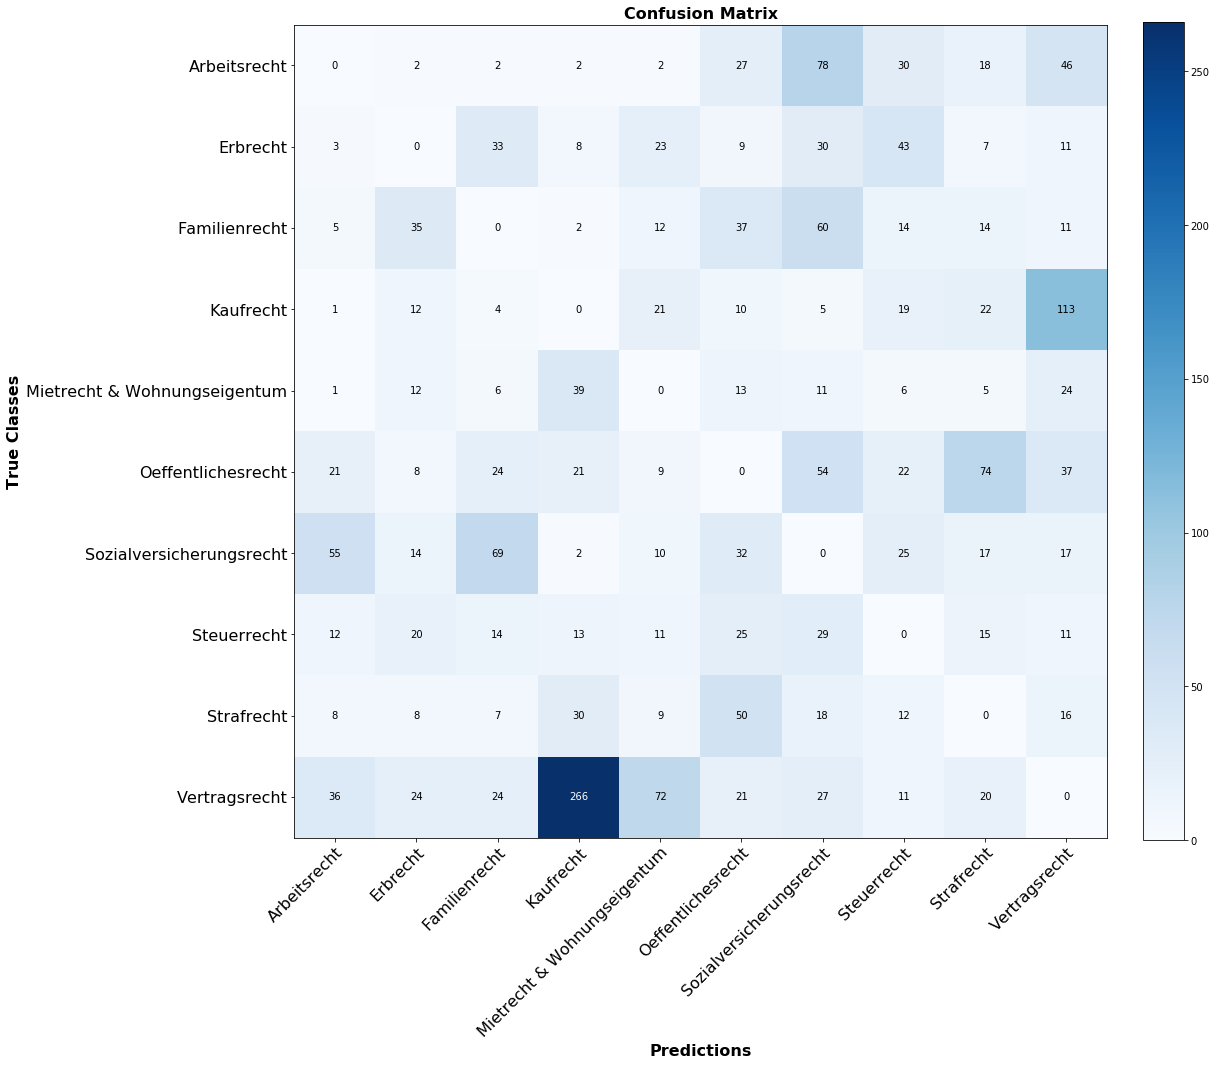

In [82]:
fig = plt.figure(figsize=(17,17))
ax=fig.subplots(1,1)
img = ax.imshow(confusion_matrix_,cmap = plt.cm.Blues)
ax.figure.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
ax.set(xticks=np.arange(confusion_matrix_.shape[1]),
           yticks=np.arange(confusion_matrix_.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=encoder.classes_, 
           yticklabels=encoder.classes_)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.set_ylabel('True Classes', fontsize = 16, weight = 'bold')
ax.set_xlabel('Predictions', fontsize = 16, weight = 'bold')
ax.set_title('Confusion Matrix', fontsize = 16, weight = 'bold')
    # Rotate the tick labels and set their alignment.
_=plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
fmt = 'd'
thresh = confusion_matrix_.max() / 2.
for i in range(confusion_matrix_.shape[0]):
    for j in range(confusion_matrix_.shape[1]):
        ax.text(j, i, format(confusion_matrix_[i, j], fmt),
                ha="center", va="center",
                color="white" if confusion_matrix_[i, j] > thresh else "black")
fig.tight_layout()
plt.savefig('confusion_matrix_classifier_dropall')

In [253]:
encoder.classes_[5]

'Oeffentlichesrecht'

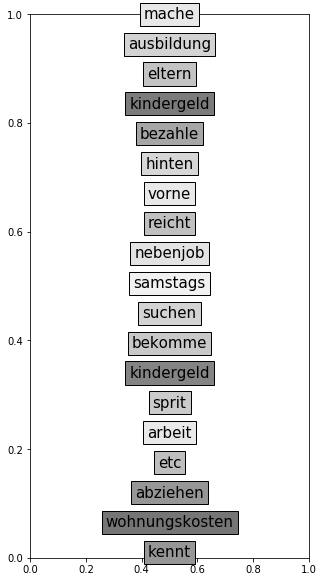

In [263]:
fig, ax = plt.subplots(figsize=(5, 10))
i = 0
cmap = plt.get_cmap('binary')
j = 0
for text, weight in zip(texts[35],weights[35][-len(texts[35]):]):
    ax.text(0.5, 1-i, text, size=15, va="center", ha="center",
            color='black', 
            bbox=dict(facecolor=cmap(weight[0]*5)))
    i+=0.055

plt.savefig('colorcoded_35_Sozialversicherungsrecht')